# The Many Variables & The Spurious Waffles

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

## 5.1 Spurious association

#### Code 5.1

In [2]:
# load data
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
# standardize predictor
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()
d['Divorce_s'] = (d.Divorce - d.Divorce.mean()) / d.Divorce.std()

#### Code 5.2

In [3]:
d.MedianAgeMarriage.std()

1.2436303013880823

#### Code 5.3

In [4]:
with pm.Model() as model_5_1:
    a = pm.Normal('a', mu=0, sd=0.2)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    # sigma = pm.Uniform('sigma', lower=0, upper=1)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_5_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 775.22draws/s] 


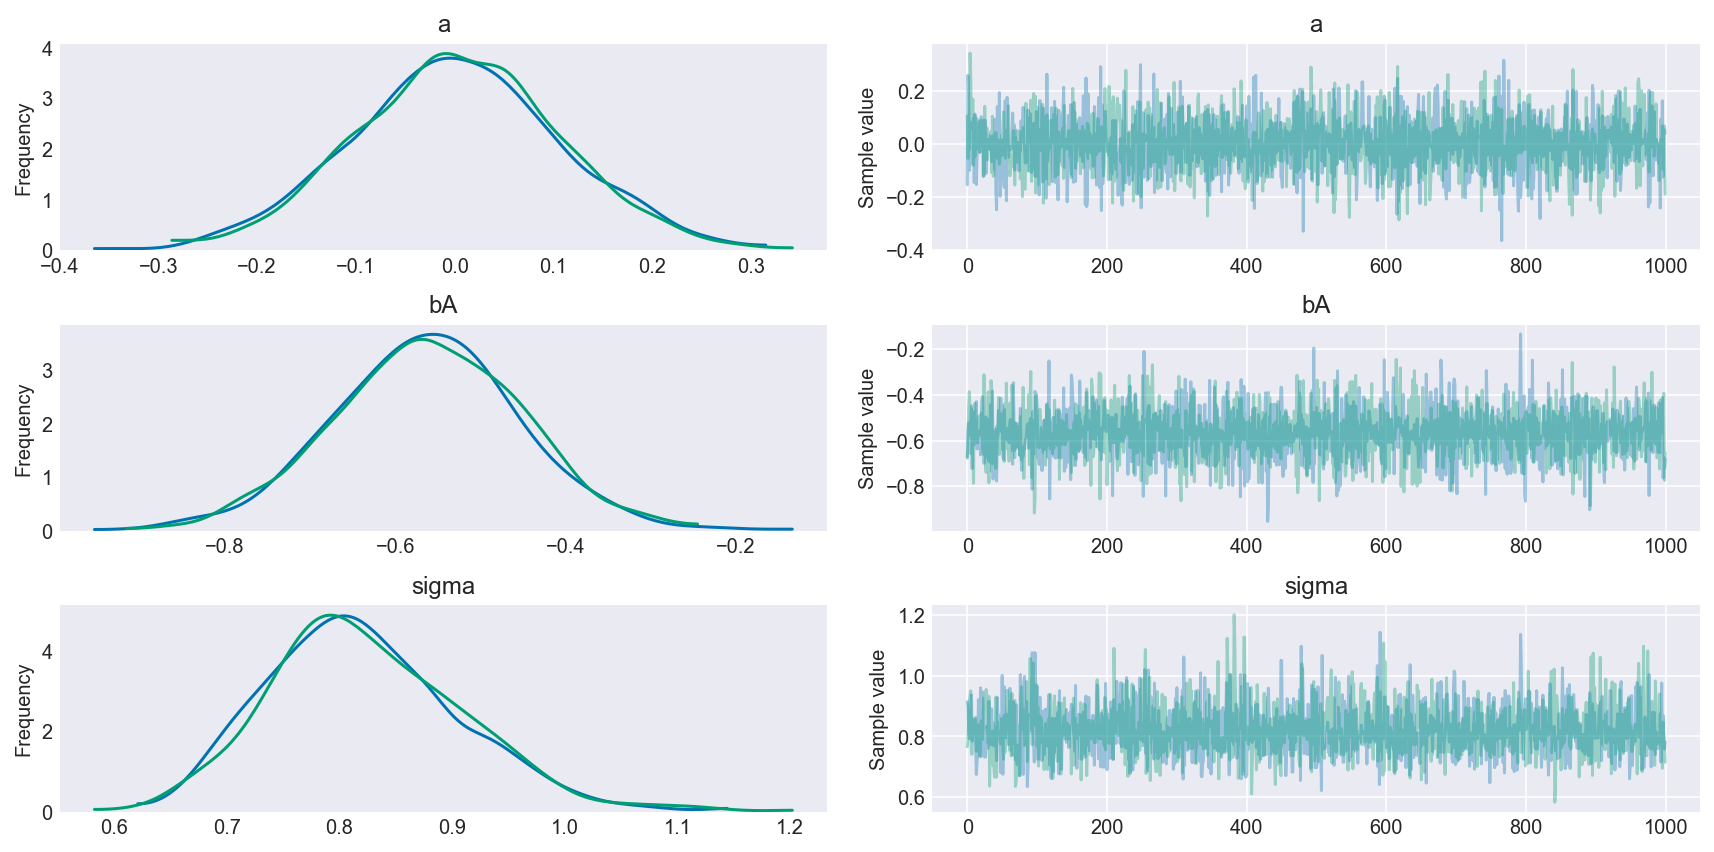

In [5]:
varnames = ['a', 'bA', 'sigma']
pm.traceplot(trace_5_1, varnames);

#### Code 5.4

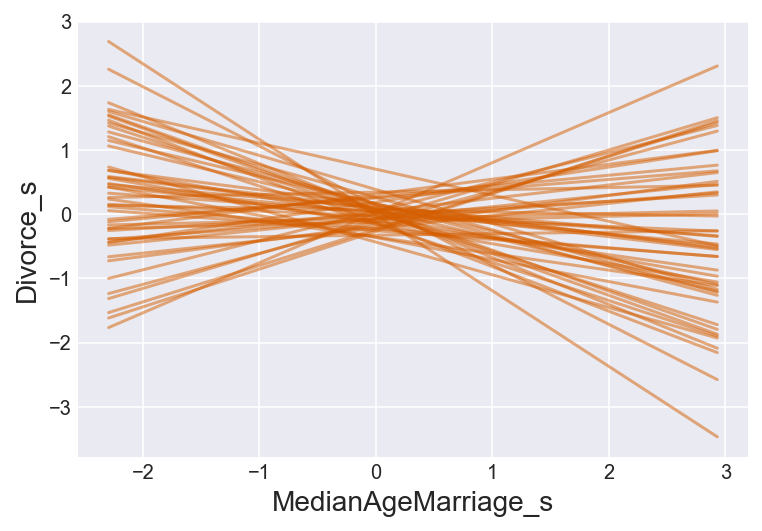

In [6]:
N = 50
a = stats.norm.rvs(loc=0, scale=0.2, size=N)
bA = stats.norm.rvs(loc=0, scale=0.5, size=N)

idx = np.argsort(d.MedianAgeMarriage_s)

for (ai, bAi) in zip(a, bA):
    divorcePred = (ai + bAi * d['MedianAgeMarriage_s'][idx])
    plt.plot(d.MedianAgeMarriage_s[idx], divorcePred , 'C2-', alpha=0.5)
plt.xlabel("MedianAgeMarriage_s", fontsize=14)
plt.ylabel("Divorce_s", fontsize=14);

#### Code 5.5

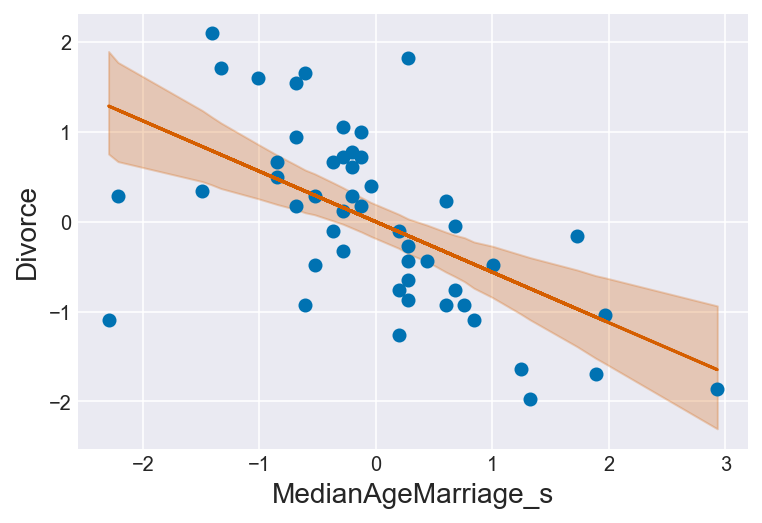

In [7]:
mu_mean = trace_5_1['mu']
mu_hpd = pm.hpd(mu_mean)

plt.plot(d.MedianAgeMarriage_s, d.Divorce_s, 'C0o')
plt.plot(d.MedianAgeMarriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.MedianAgeMarriage_s)
plt.fill_between(d.MedianAgeMarriage_s[idx],
                 mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage_s', fontsize=14)
plt.ylabel('Divorce', fontsize=14);

#### Code 5.6

In [8]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

In [9]:
with pm.Model() as model_5_2:
    a = pm.Normal('a', mu=0, sd=0.2)
    bM = pm.Normal('bM', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM * d.Marriage_s)
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_5_2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bM, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1248.92draws/s]


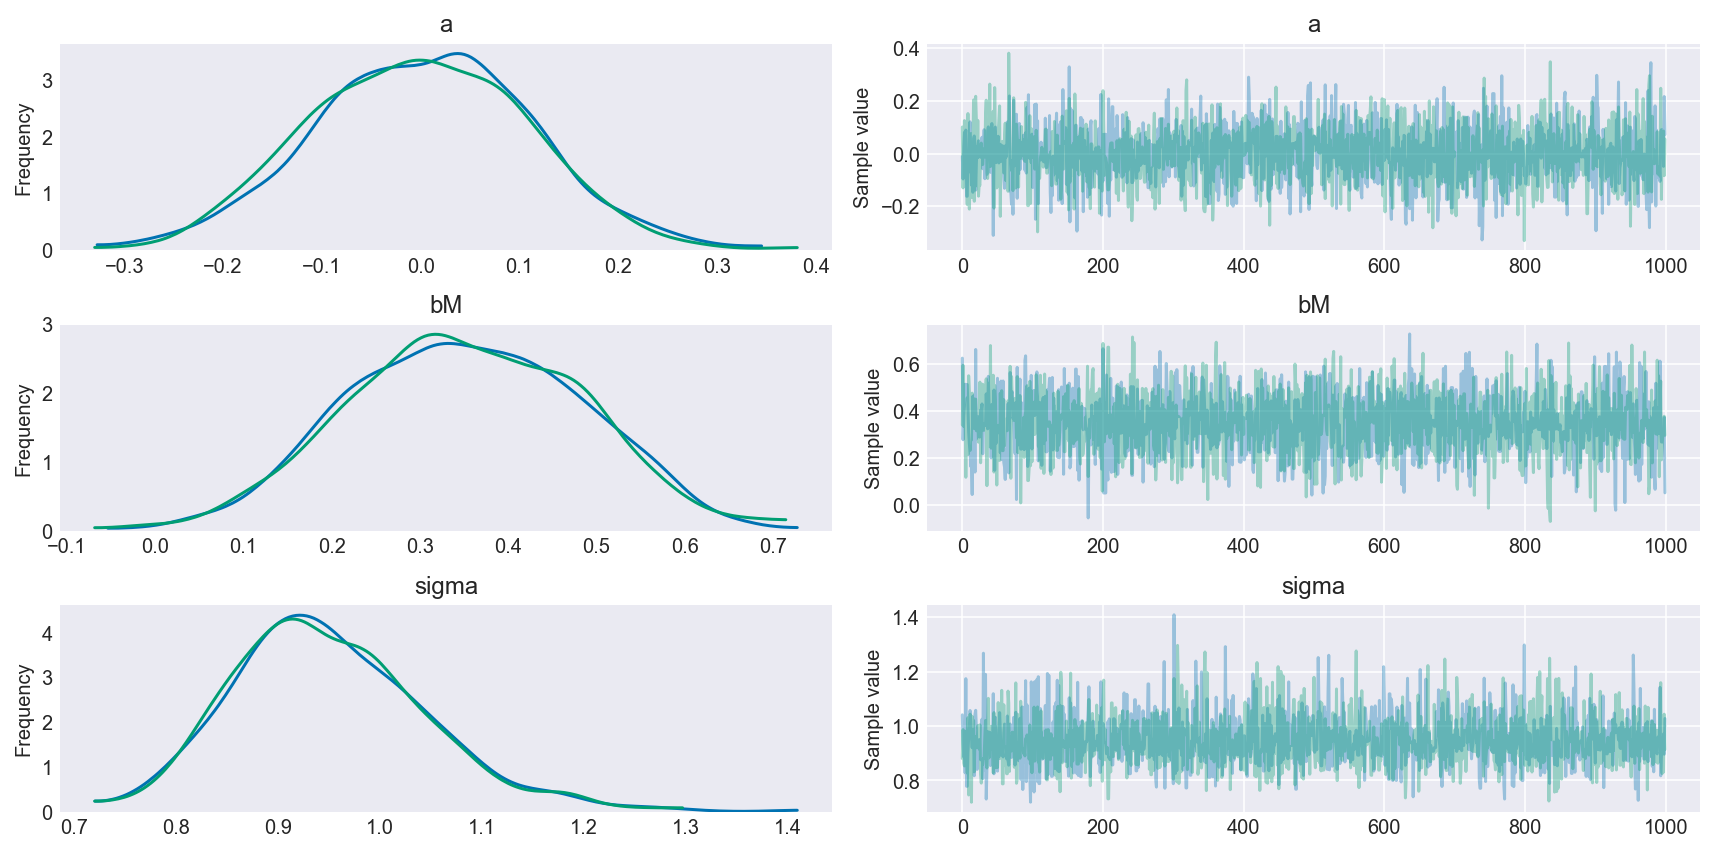

In [10]:
pm.traceplot(trace_5_2, ['a', 'bM','sigma']);

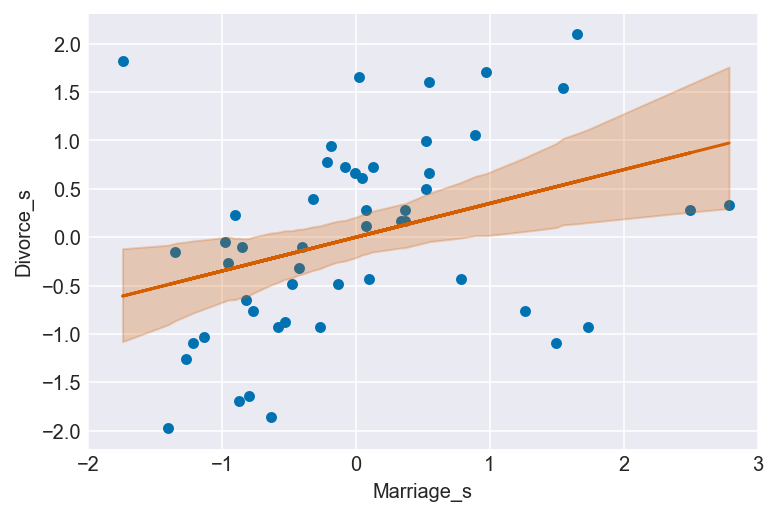

In [11]:
mu_mean = trace_5_2['mu']
mu_hpd = pm.hpd(mu_mean)

d.plot('Marriage_s', 'Divorce_s', kind='scatter', xlim = (-2, 3))
plt.plot(d.Marriage_s, mu_mean.mean(0), 'C2')

idx = np.argsort(d.Marriage_s)
plt.fill_between(d.Marriage_s[idx], mu_hpd[:,0][idx], mu_hpd[:,1][idx],
                 color='C2', alpha=0.25);

### 5.1.1. Think before you regress

#### Code 5.7

In [12]:
# TODO: Find a DAG drawing package for python

### 5.1.2. Multiple regression notation

### 5.1.3. Approximating the posterior

#### Code 5.8

In [13]:
with pm.Model() as model_5_3:
    a = pm.Normal('a', mu=0, sd=0.2)
    bM = pm.Normal('bM', mu=0, sd=0.5)
    bA = pm.Normal('bA', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bM * d.Marriage_s + bA * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce_s)
    trace_5_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, bM, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 707.36draws/s]


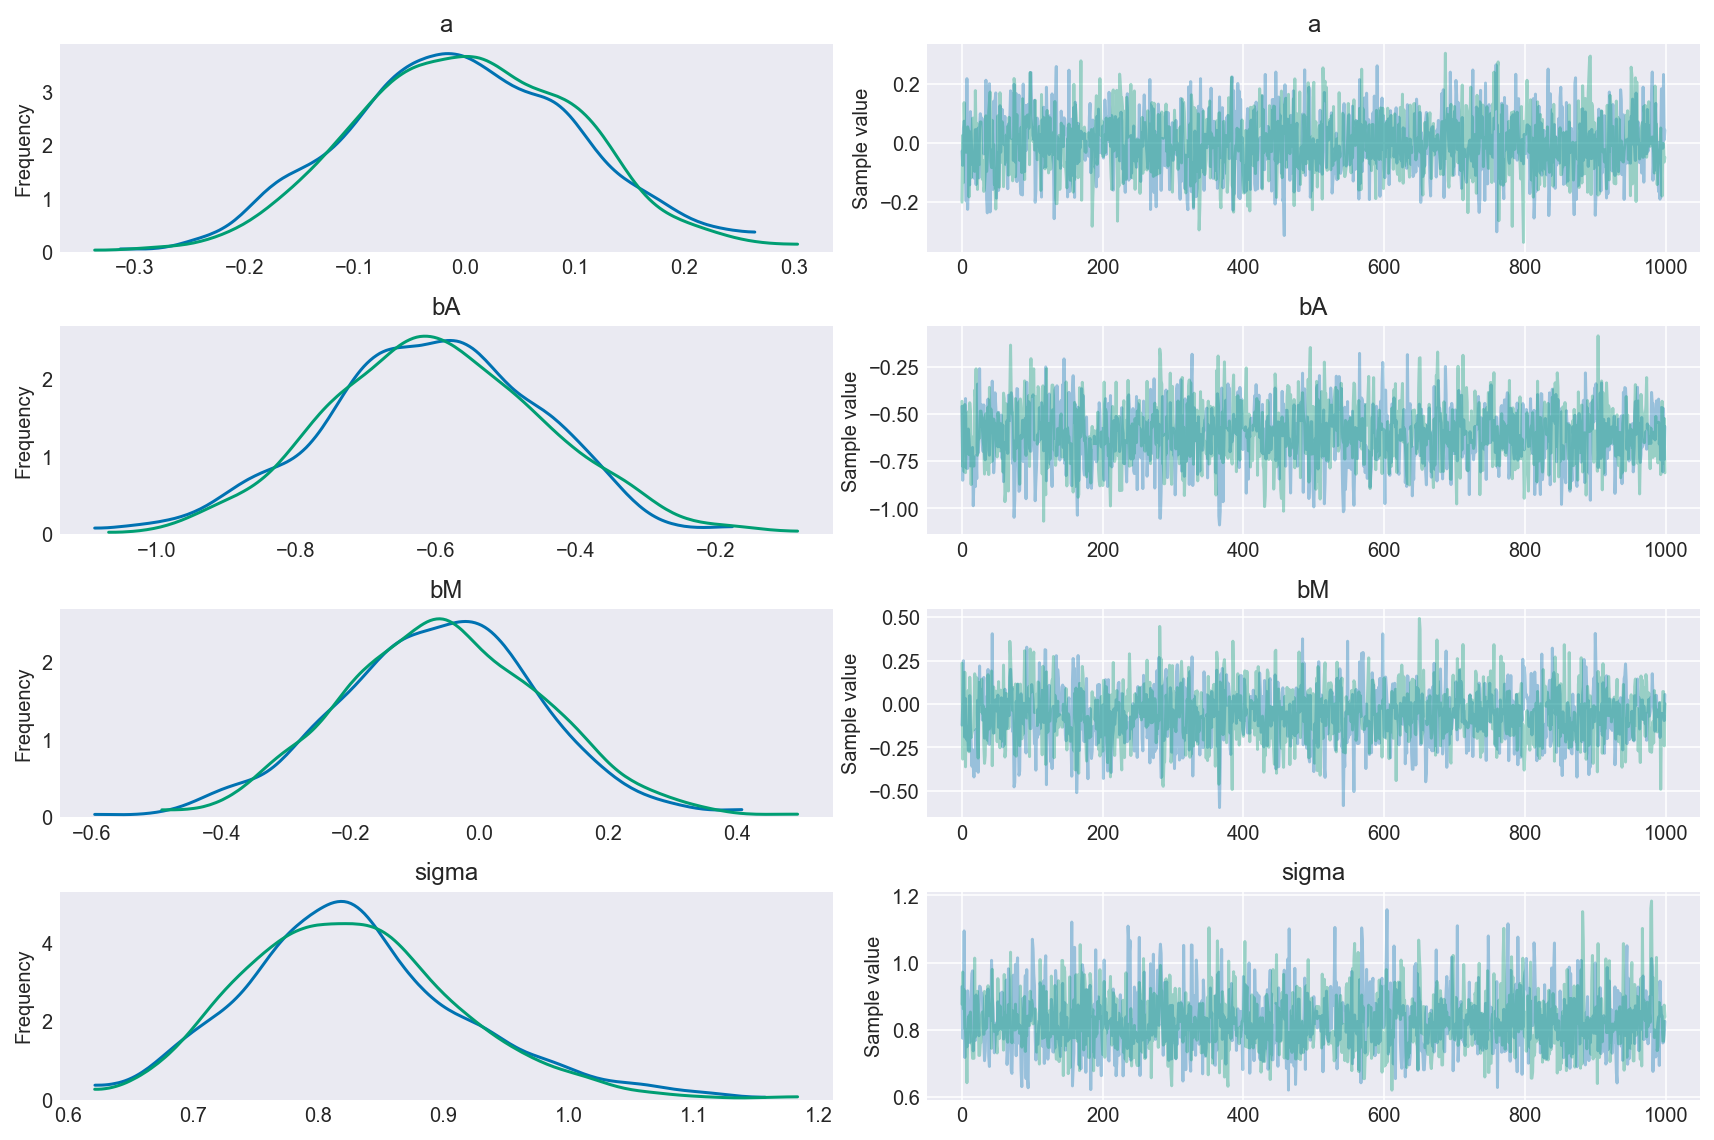

In [15]:
varnames = ['a', 'bA', 'bM', 'sigma']
pm.traceplot(trace_5_3, varnames);

In [16]:
pm.summary(trace_5_3, varnames, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.00,0.10,0.0,-0.17,0.15,1843.84,1.0
bA,-0.61,0.16,0.0,-0.86,-0.36,1393.46,1.0
bM,-0.06,0.16,0.0,-0.31,0.17,1472.46,1.0
sigma,0.83,0.09,0.0,0.67,0.95,1677.41,1.0


#### Code 5.9

In [27]:
pm.forestplot?

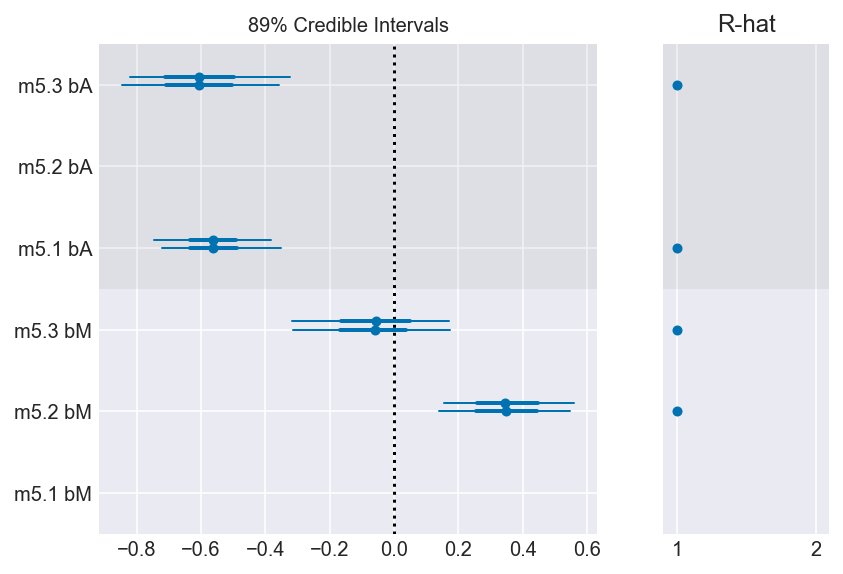

In [28]:
pm.forestplot([trace_5_3, trace_5_2, trace_5_1], models=["m5.3", "m5.2", "m5.1"], varnames=['bA', 'bM'], alpha=0.11);

##### Code 5.10

In [32]:
N = 50
age = stats.norm.rvs(size=N)
mar = stats.norm.rvs(size=N)
div = stats.norm.rvs(size=N)

# TODO: Fit the previous models with this data and see the similar results

### 5.1.4. Plotting multivariate posteriors

#### 5.1.4.1. Predictor residual plots

##### Code 5.11

In [33]:
with pm.Model() as model_5_4:
    a = pm.Normal('a', mu=0, sd=0.2)
    b = pm.Normal('b', mu=0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + b * d.MedianAgeMarriage_s)
    Marriage = pm.Normal('Marriage', mu=mu, sd=sigma, observed=d.Marriage_s)
    trace_5_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1334.55draws/s]


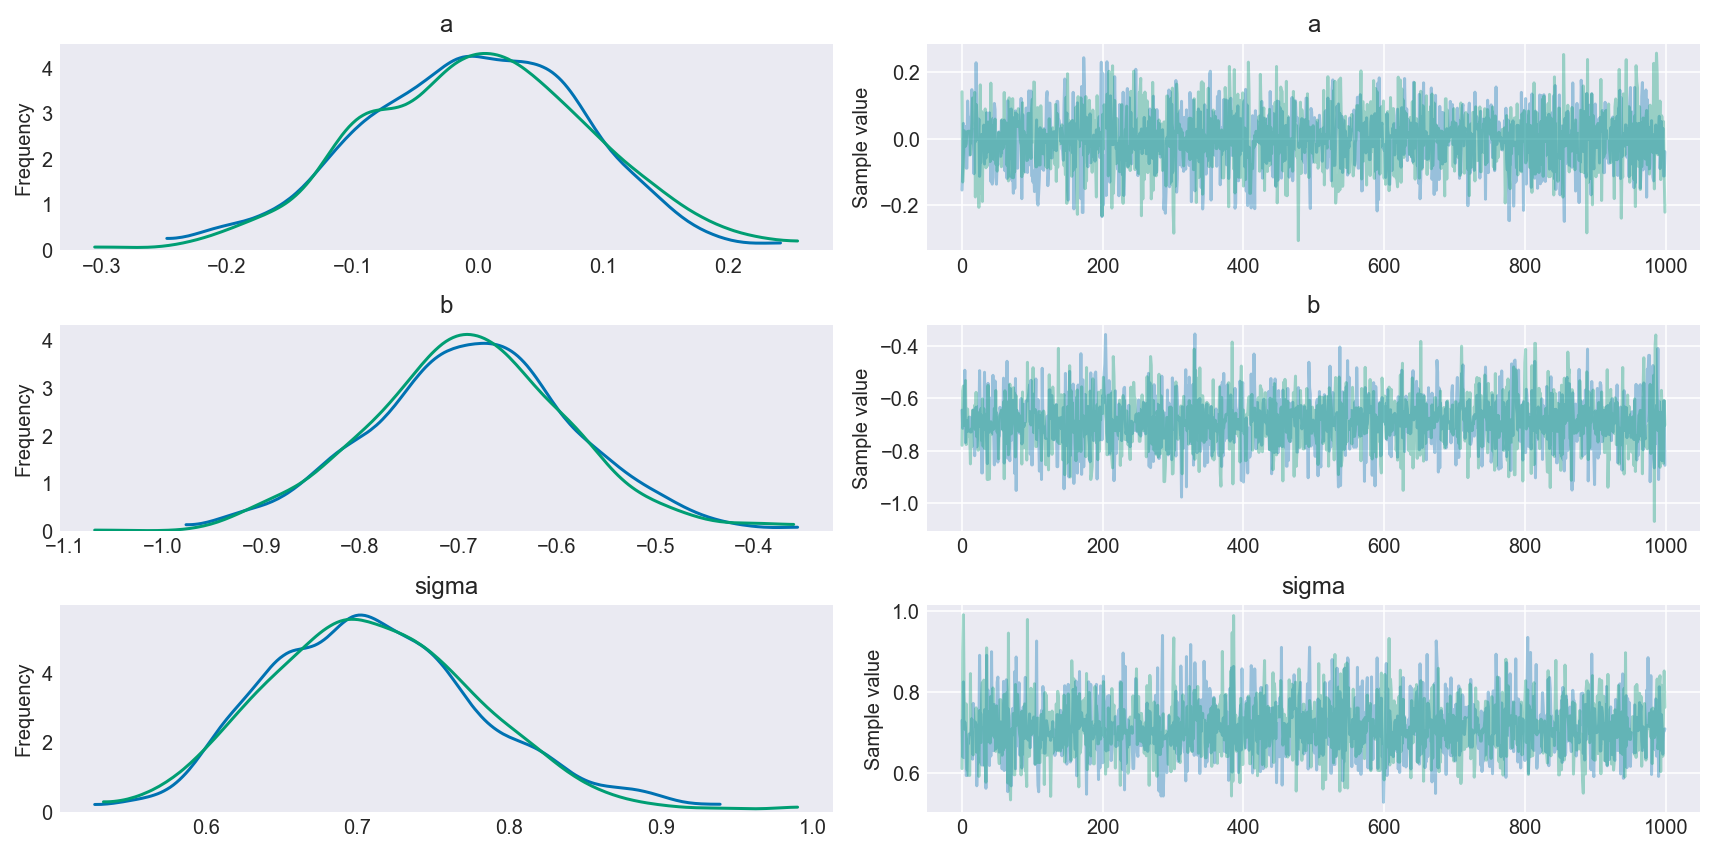

In [34]:
varnames = ['a', 'b', 'sigma']
pm.traceplot(trace_5_4, varnames);

##### Code 5.12

In [35]:
mu_pred = trace_5_4['mu'].mean(0)
residuals = d.Marriage_s - mu_pred

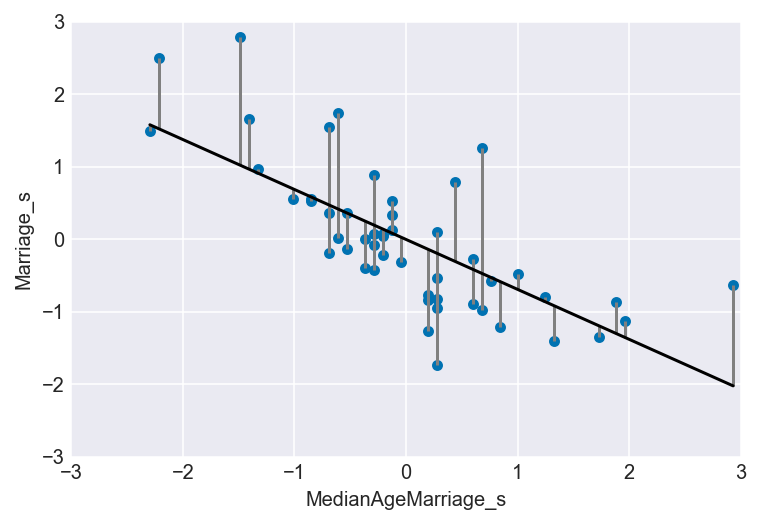

In [36]:
idx = np.argsort(d.MedianAgeMarriage_s)
d.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim = (-3, 3), ylim = (-3, 3))
plt.plot(d.MedianAgeMarriage_s[idx], mu_pred[idx], 'k')
plt.vlines(d.MedianAgeMarriage_s, mu_pred, mu_pred + residuals, colors='grey');

In [38]:
# TODO: Do all the plots in FIGURE 5.4

#### 5.1.4.2. Counterfactual plots

##### Code 5.13

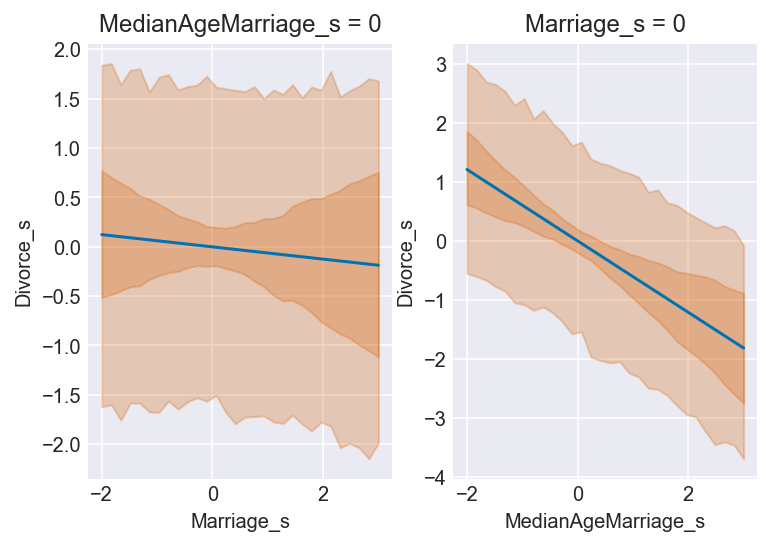

In [50]:
R_avg = np.linspace(-2, 3, 30)

mu_pred = trace_5_3['a'] + trace_5_3['bM'] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.subplot(1, 2, 1)
plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('Marriage_s')
plt.ylabel('Divorce_s')
plt.title('MedianAgeMarriage_s = 0');

mu_pred = trace_5_3['a'] + trace_5_3['bA'] * R_avg[:,None]
mu_hpd = pm.hpd(mu_pred.T)
divorce_hpd = pm.hpd(stats.norm.rvs(mu_pred, trace_5_3['sigma']).T)

plt.subplot(1, 2, 2)
plt.plot(R_avg, mu_pred.mean(1), 'C0');
plt.fill_between(R_avg, mu_hpd[:,0], mu_hpd[:,1], color='C2', alpha=0.25)
plt.fill_between(R_avg, divorce_hpd[:,0], divorce_hpd[:,1], color='C2', alpha=0.25)

plt.xlabel('MedianAgeMarriage_s')
plt.ylabel('Divorce_s')
plt.title('Marriage_s = 0');

#### 5.1.4.3. Posterior prediction plots

##### Code 5.14

In [53]:
mu_pred = trace_5_3['mu']
mu_hpd = pm.hpd(mu_pred, alpha=0.11)

divorce_pred = pm.sample_ppc(trace_5_3, samples=1000, model=model_5_3)['Divorce']
divorce_hpd = pm.hpd(divorce_pred, alpha=0.11)

/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
100%|██████████| 1000/1000 [00:00<00:00, 1329.06it/s]


##### Code 5.15

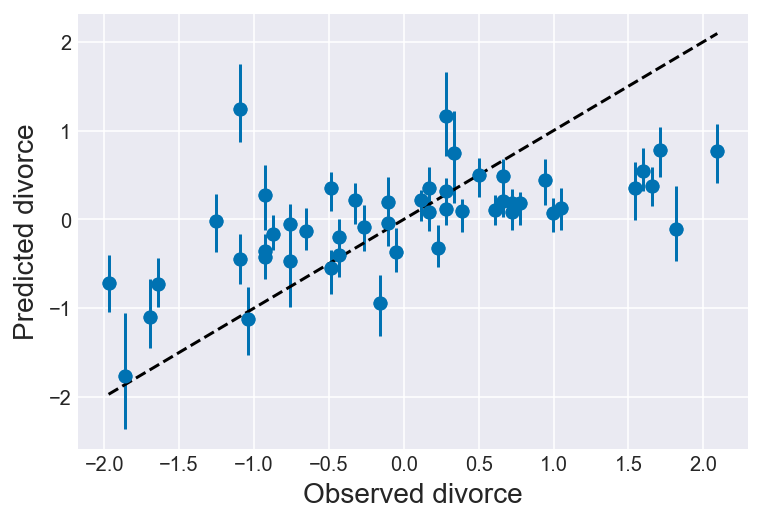

In [55]:
mu_hpd = pm.hpd(mu_pred, alpha=0.11)
plt.errorbar(d.Divorce_s, divorce_pred.mean(0), yerr=np.abs(divorce_pred.mean(0)-mu_hpd.T) , fmt='C0o')
plt.plot(d.Divorce_s, divorce_pred.mean(0), 'C0o')

plt.xlabel('Observed divorce', fontsize=14)
plt.ylabel('Predicted divorce', fontsize=14)

min_x, max_x = d.Divorce_s.min(), d.Divorce_s.max()
plt.plot([min_x, max_x], [min_x, max_x], 'k--');

##### Code 5.16

In [56]:
# TODO: Investigate a way of identifying dots in a python plot similar to `identify` in the book

Extra code that doesn't appear in the book anymore

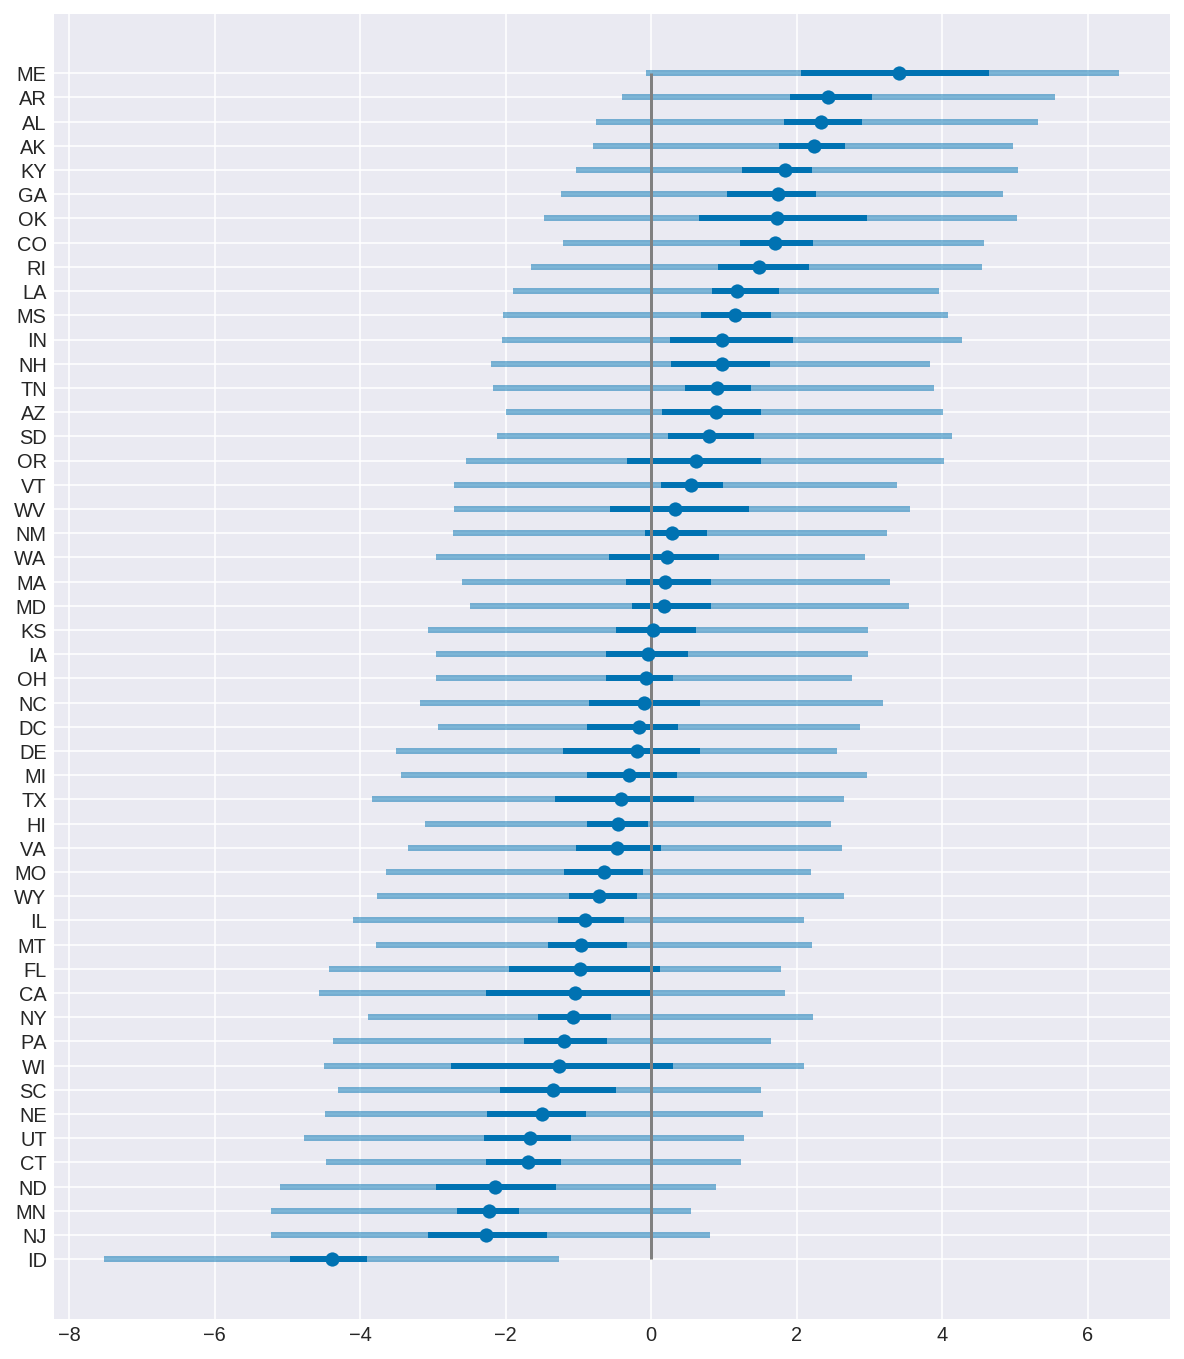

In [22]:
plt.figure(figsize=(10,12))
residuals = d.Divorce - mu_pred.mean(0)
idx = np.argsort(residuals)
y_label = d.Loc[idx]
y_points = np.linspace(0, 1, 50)
plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-mu_hpd.T),
             fmt='C0o',lw=3)

plt.errorbar(residuals[idx], y_points, 
             xerr=np.abs(divorce_pred.mean(0)-divorce_hpd.T),
             fmt='C0o', lw=3, alpha=0.5)

plt.yticks(y_points, y_label);
plt.vlines(0, 0, 1, 'grey');

##### Code 5.x

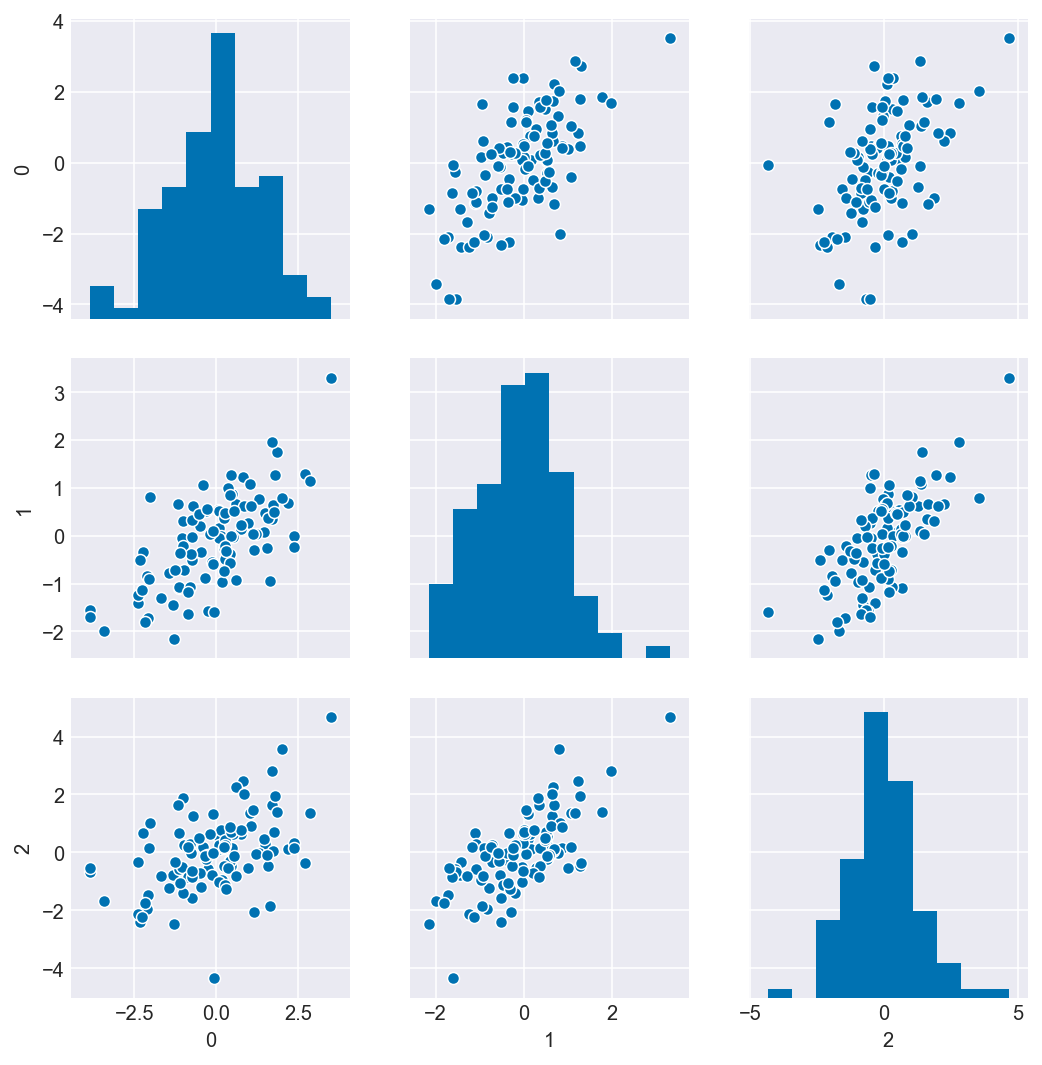

In [57]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

In [58]:
# TODO: do linear regression to detect the spurius correlation of x_spur and y

## 5.2. Masked relationship

##### Code 5.18

In [6]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [7]:
d.shape

(29, 8)

##### Code 5.19

In [13]:
def standardize(col):
    return (col - col.mean())/col.std()

In [14]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

##### Code 5.20

In [16]:
with pm.Model() as model_5_5_draft:
    a = pm.Normal('a', mu=0, sd=1)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * d["K"])
    k = pm.Normal('k', mu=mu, sd=sigma, observed=d['K'])
    trace_5_5_draft = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains:  39%|███▉      | 1559/4000 [00:13<00:20, 118.87draws/s]


RuntimeError: Chain 1 failed.

The error is different from the book but it is still there.

##### Code 5.21

In [17]:
d["neocortex.perc"].head()

0    55.16
1      NaN
2      NaN
3      NaN
4      NaN
Name: neocortex.perc, dtype: float64

##### Code 5.22

In [18]:
dcc = d.dropna().copy()

In [19]:
dcc.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082


In [20]:
dcc.shape

(17, 11)

##### Code 5.23

In [21]:
with pm.Model() as model_5_5:
    a = pm.Normal('a', mu=0, sd=1)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Exponential('sigma', lam=1)
    mu = pm.Deterministic('mu', a + bn * dcc["N"])
    k = pm.Normal('k', mu=mu, sd=sigma, observed=dcc['K'])
    trace_5_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bn, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1232.28draws/s]


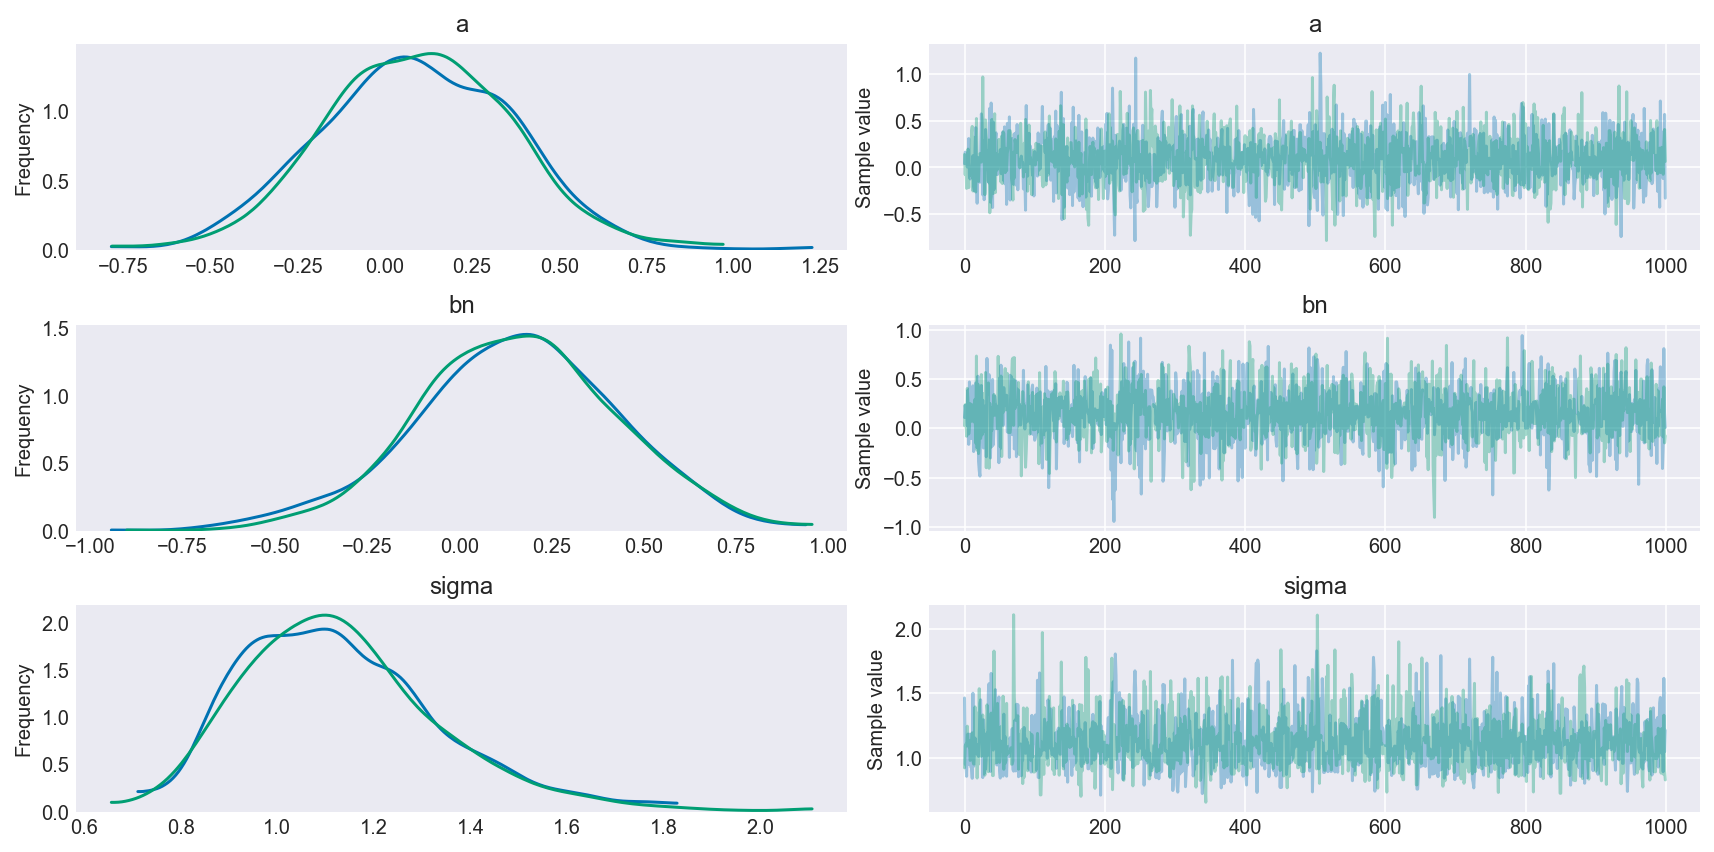

In [22]:
varnames = ['a', 'bn', 'sigma']
pm.traceplot(trace_5_5, varnames);

Now is the turn for priors and code 5.24

#### Code 5.21

In [28]:
pm.summary(trace_5_5, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.337,0.572,0.023,-0.563,1.206,556.622,1.0
bn,0.005,0.008,0.000,-0.007,0.019,562.039,1.0
sigma,0.193,0.038,0.001,0.139,0.252,730.180,1.0


#### Code 5.22

In [29]:
trace_5_5['bn'].mean() * (76 - 55)

0.1000873209257025

#### Code 5.23

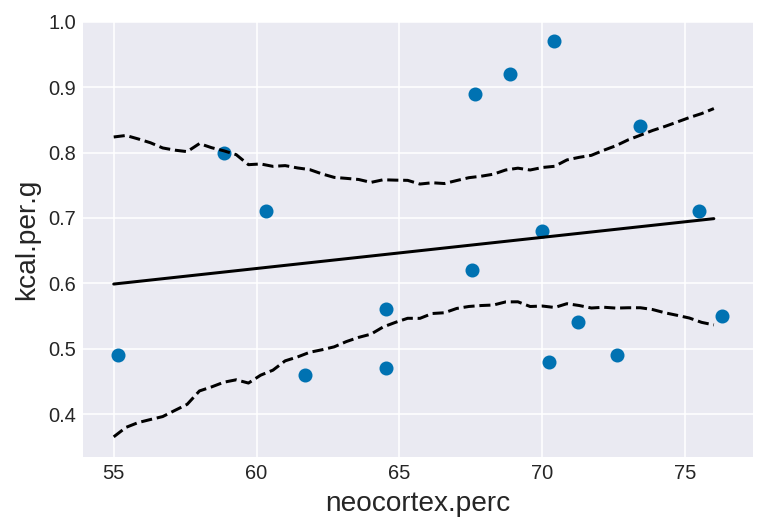

In [30]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_5['a'] + trace_5_5['bn'] * seq[:,None]
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(d['neocortex.perc'], d['kcal.per.g'], 'C0o')

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc', fontsize=14)
plt.ylabel('kcal.per.g', fontsize=14);

#### Code 5.24

In [31]:
dcc['log_mass'] = np.log(dcc['mass'])

#### Code 5.25

In [32]:
with pm.Model() as model_5_6:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bn, a]
100%|██████████| 2000/2000 [00:01<00:00, 1338.17it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [33]:
pm.summary(trace_5_6, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.706,0.058,0.002,0.602,0.787,956.951,1.004
bn,-0.031,0.024,0.001,-0.070,0.006,1045.460,1.001
sigma,0.184,0.037,0.001,0.126,0.232,1181.957,1.000


#### Code 5.26

In [34]:
with pm.Model() as model_5_7:
    a = pm.Normal('a', mu=10, sd=100)
    bn = pm.Normal('bn', mu=0, sd=1, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=1)
    mu = pm.Deterministic('mu', a + bn[0] * dcc['neocortex.perc'] + bn[1] * dcc['log_mass'])
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=dcc['kcal.per.g'])
    trace_5_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bn, a]
100%|██████████| 2000/2000 [00:12<00:00, 161.02it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [35]:
pm.summary(trace_5_7, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.080,0.618,0.026,-2.079,-0.067,518.362,1.000
bn__0,0.028,0.010,0.000,0.012,0.044,511.733,1.000
bn__1,-0.096,0.029,0.001,-0.145,-0.055,621.182,1.000
sigma,0.141,0.031,0.001,0.097,0.185,459.563,1.005


#### Code 5.27

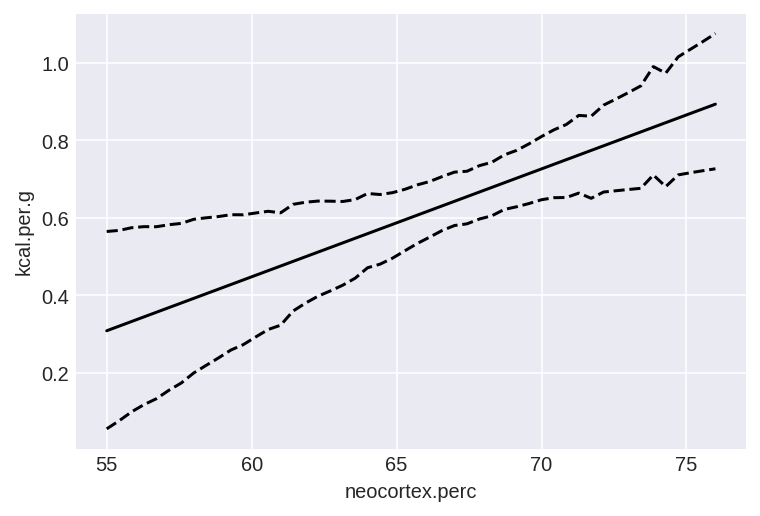

In [36]:
seq = np.linspace(55, 76, 50)
mu_pred = trace_5_7['a'] + trace_5_7['bn'][:,0] * seq[:,None] + trace_5_7['bn'][:,1] * dcc['log_mass'].mean()
mu_hpd = pm.hpd(mu_pred.T)

plt.plot(seq, mu_pred.mean(1), 'k')
plt.plot(seq, mu_hpd[:,0], 'k--')
plt.plot(seq, mu_hpd[:,1], 'k--')

plt.xlabel('neocortex.perc')
plt.ylabel('kcal.per.g');

#### Code 5.28

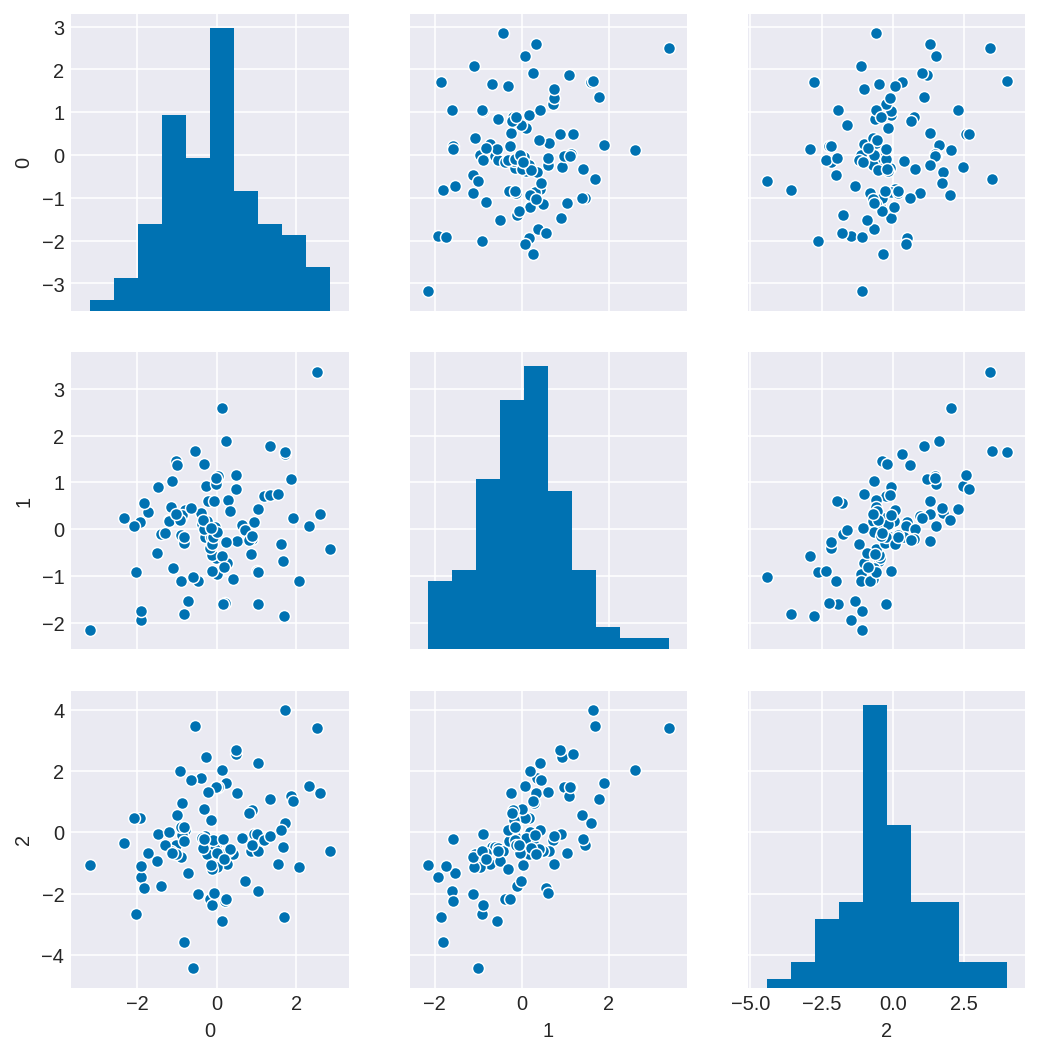

In [37]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(rho*x_pos, (1-rho**2)**0.5)
y = stats.norm.rvs(x_pos - x_neg)
d = pd.DataFrame([y, x_real, x_spur]).T

sns.pairplot(d);

#### Code 5.29

In [38]:
N = 100
height = stats.norm.rvs(size=N, loc=10, scale=2)
leg_prop = stats.uniform.rvs(size=N, loc=0.4, scale=0.5) 
leg_left = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)
leg_right = leg_prop * height + stats.norm.rvs(size=N, loc=0, scale=0.02)

#### Code 5.30

In [39]:
with pm.Model() as m5_8:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * leg_left + br * leg_right)    
    sigma = pm.Uniform('sigma', lower=0 , upper=10)
    height_p = pm.Normal('height_p', mu=mu, sd=sigma, observed=height)
    
    trace_5_8 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, br, bl, a]
100%|██████████| 2000/2000 [01:54<00:00, 17.46it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,6.037,0.563,0.015,5.167,6.908,1302.866,1.000
bl,1.875,4.556,0.148,-5.364,9.063,815.188,1.001
br,-1.260,4.548,0.148,-8.584,5.841,817.093,1.001
sigma,1.515,0.112,0.003,1.341,1.688,930.517,1.007


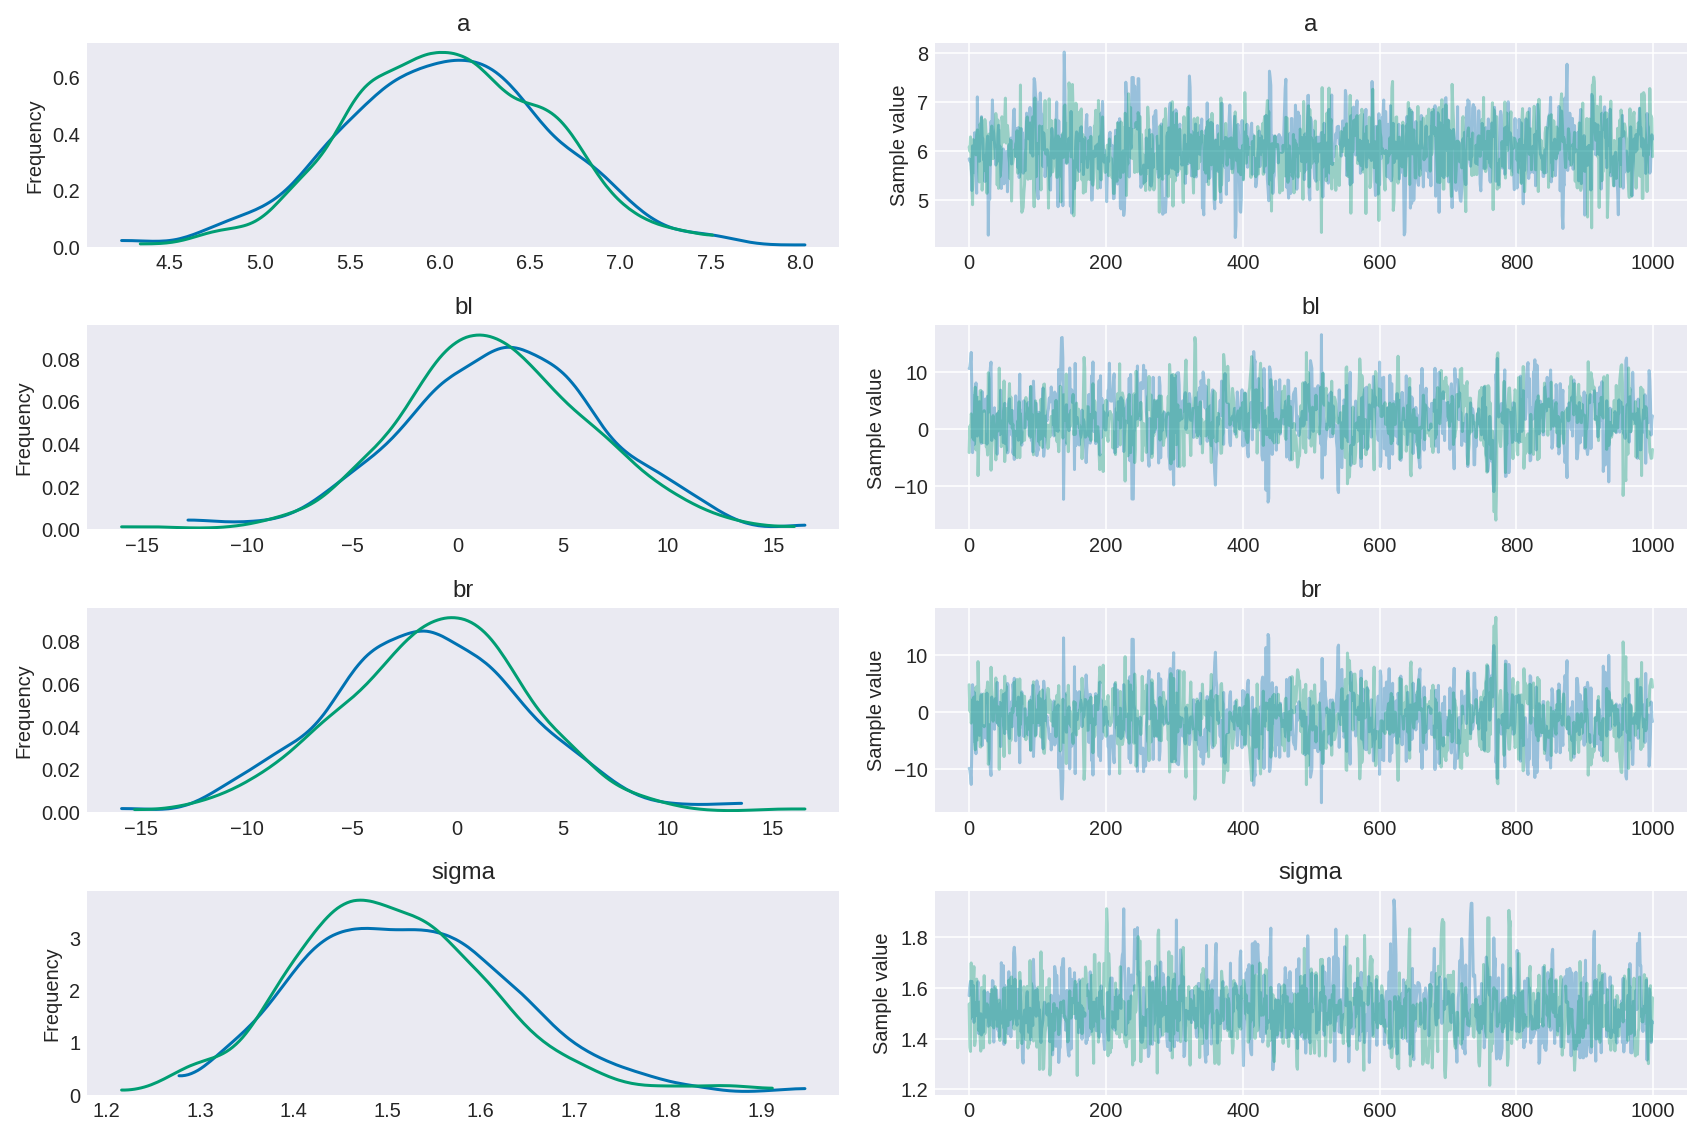

In [40]:
varnames=['a', 'bl', 'br', 'sigma']
pm.traceplot(trace_5_8, varnames);
pm.summary(trace_5_8, varnames, alpha=.11).round(3)

#### Code 5.31

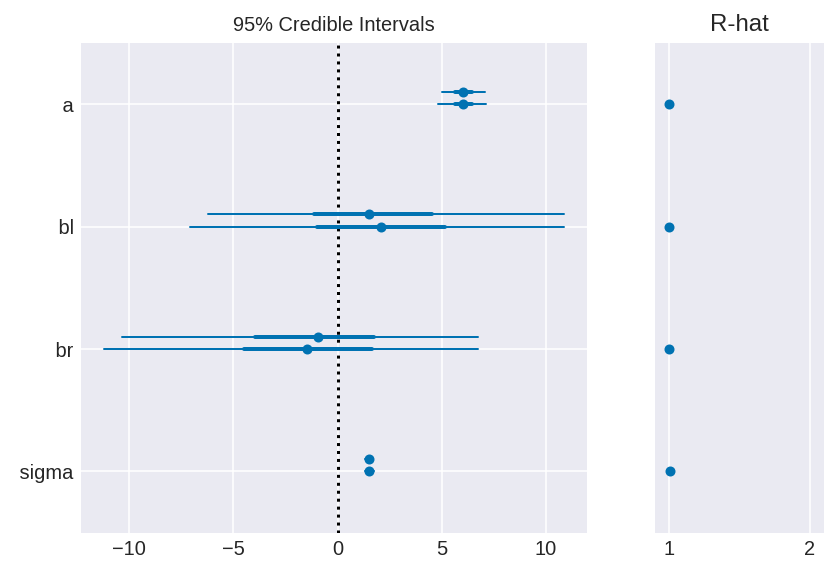

In [41]:
pm.forestplot(trace_5_8, varnames=varnames);

#### Code 5.32

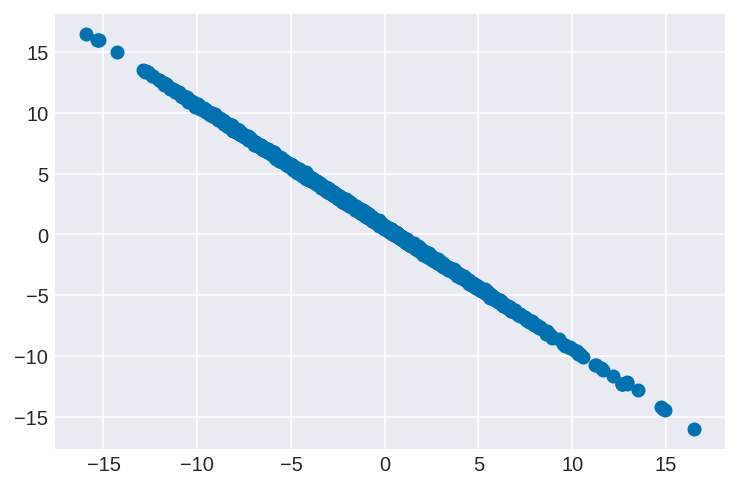

In [42]:
plt.scatter(trace_5_8['br'], trace_5_8['bl']);

#### Code 5.33

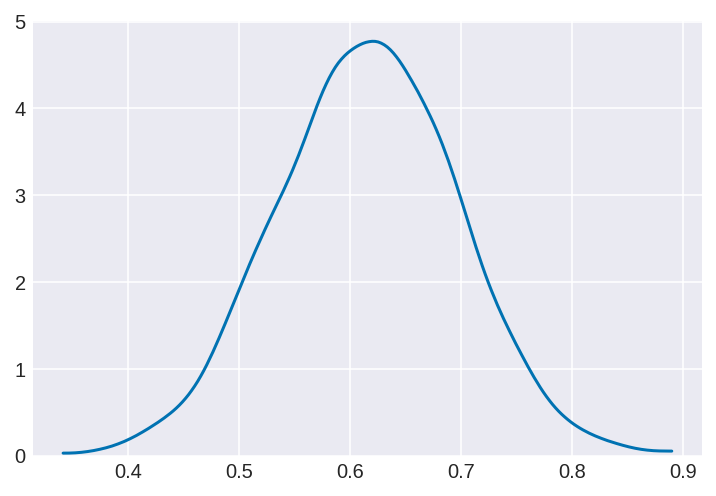

In [43]:
sum_blbr = trace_5_8['br'] + trace_5_8['bl']
pm.kdeplot(sum_blbr);

#### Code 5.34

In [44]:
with pm.Model() as m5_9:
    a = pm.Normal('a',mu = 10, sd=100)
    bl = pm.Normal('bl',mu=2, sd= 10)
    mu = pm.Deterministic('mu',a + bl * leg_left)    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    height = pm.Normal('height',mu=mu, sd=sigma, observed=height)
    trace_5_9 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bl, a]
100%|██████████| 2000/2000 [00:02<00:00, 671.18it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [45]:
varnames_1 = ['a', 'bl', 'sigma']
#pm.traceplot(trace_5_9, varnames_1)
pm.summary(trace_5_9, varnames_1, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,6.025,0.555,0.019,5.191,6.923,840.553,1.0
bl,0.616,0.079,0.003,0.490,0.737,844.931,1.0
sigma,1.505,0.109,0.003,1.337,1.673,850.426,1.0


#### Code 5.35

In [46]:
milk = pd.read_csv('Data/milk.csv', sep=';')
milk.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### Code 5.36

In [47]:
with pm.Model() as m5_10:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bf, a]
100%|██████████| 2000/2000 [00:02<00:00, 918.55it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [48]:
varnames = ['a', 'bf', 'sigma']
pm.summary(trace_5_10, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.304,0.040,0.001,0.234,0.361,758.034,1.0
bf,0.010,0.001,0.000,0.008,0.012,736.968,1.0
sigma,0.080,0.012,0.000,0.061,0.097,1063.684,1.0


In [49]:
with pm.Model() as m5_11:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bl, a]
100%|██████████| 2000/2000 [00:03<00:00, 658.16it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8872753989064099, but should be close to 0.8. Try to increase the number of tuning steps.


In [50]:
varnames = ['a', 'bl', 'sigma']
pm.summary(trace_5_11, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.167,0.046,0.002,1.091,1.240,769.307,1.000
bl,-0.011,0.001,0.000,-0.012,-0.009,741.460,1.000
sigma,0.067,0.010,0.000,0.051,0.082,777.390,1.003


#### Code 5.37

In [51]:
with pm.Model() as m5_12:
    a = pm.Normal('a',mu = 0.6, sd=10)
    bf = pm.Normal('bf',mu=0, sd= 1)
    bl = pm.Normal('bl',mu=0, sd= 1)
    mu = pm.Deterministic('mu',a + bf * milk['perc.fat'] + bl * milk['perc.lactose'])    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcalperg = pm.Normal('kcal.per.g',mu=mu, sd=sigma, observed=milk['kcal.per.g'])
    trace_5_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bl, bf, a]
100%|██████████| 2000/2000 [00:08<00:00, 236.96it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [52]:
varnames = ['a', 'bf', 'bl', 'sigma']
pm.summary(trace_5_12, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.999,0.219,0.009,0.628,1.334,549.959,1.001
bf,0.002,0.003,0.000,-0.002,0.006,575.475,1.001
bl,-0.009,0.003,0.000,-0.012,-0.004,546.975,1.002
sigma,0.067,0.011,0.001,0.050,0.083,218.618,1.000


#### Code 5.38

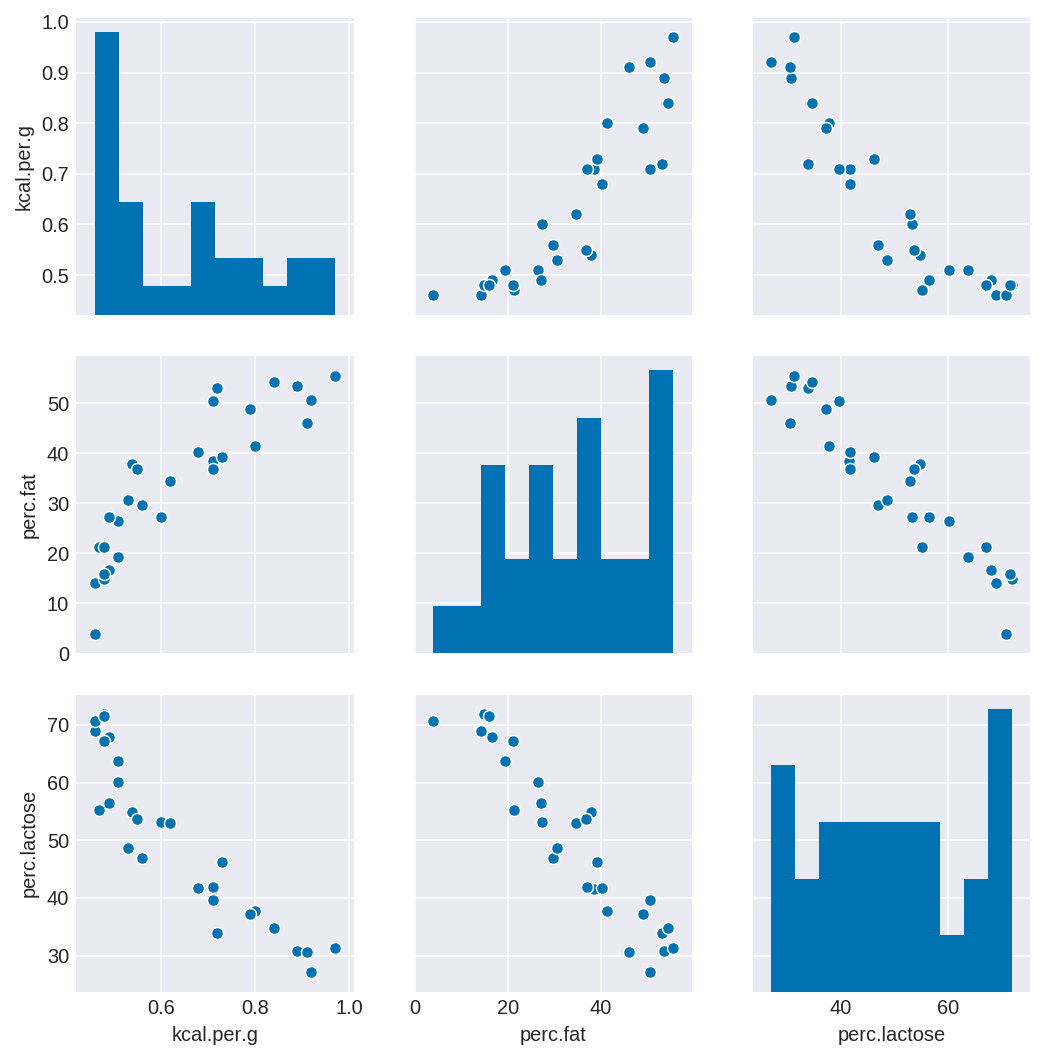

In [53]:
df = milk[['kcal.per.g','perc.fat','perc.lactose']]
sns.pairplot(df);

#### Code 5.39

In [54]:
milk.corr()['perc.fat']['perc.lactose']

-0.9416373456839282

#### Code 5.40

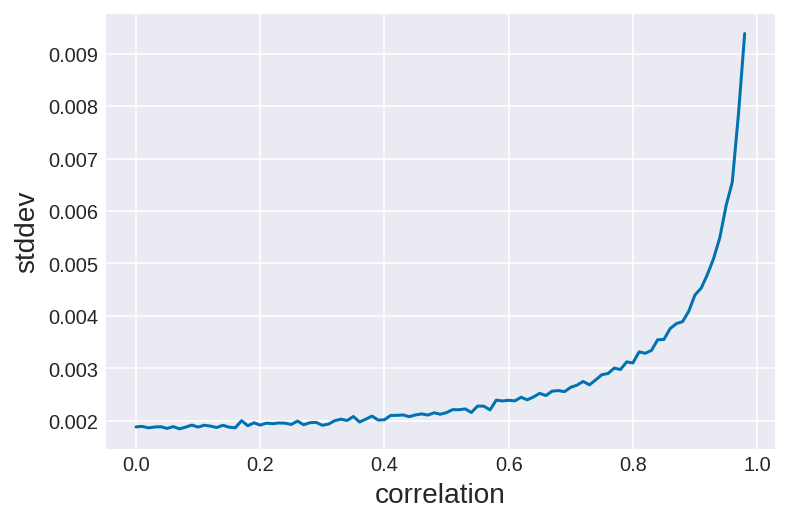

In [55]:
def simcoll(r = 0.9):
    milk['x'] = stats.norm.rvs(size=len(milk), loc = r * milk['perc.fat'],
                       scale = np.sqrt((1 - r**2) * milk['perc.fat'].var()))
    X = np.column_stack((milk['perc.fat'], milk['x']))
    m = smf.OLS(milk['kcal.per.g'], X).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 5.41

In [56]:
# number of plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(size = N, loc = 10, scale = 2)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = np.random.binomial(n=1, p=(0.5-treatment * 0.4), size=N)
h1 = h0 + stats.norm.rvs(size= N, loc= 5- 3*fungus, scale=1)

# compose a clean data frame
d = pd.DataFrame({'h0': h0,
                  'h1': h1,
                  'Treatment':treatment,
                  'Fungus': fungus})

#### Code 5.42

In [57]:
with pm.Model() as m5_13:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    bf = pm.Normal('bf',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment + bf * fungus)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed = d['h1'].get_values())
    trace_5_13 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bf, bt, bh, a]
100%|██████████| 2000/2000 [00:04<00:00, 408.44it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [58]:
varnames = ['a', 'bh', 'bt', 'bf', 'sigma']
pm.summary(trace_5_13, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.069,0.525,0.018,4.250,5.882,806.782,1.002
bh,0.996,0.048,0.002,0.915,1.066,815.781,1.003
bt,-0.223,0.228,0.007,-0.579,0.160,1099.064,1.000
bf,-2.905,0.245,0.008,-3.324,-2.552,1020.728,1.002
sigma,0.974,0.074,0.002,0.856,1.093,1409.631,1.000


#### Code 5.43

In [59]:
with pm.Model() as m5_14:
    a = pm.Normal('a',mu = 0, sd=100)
    bh = pm.Normal('bh',mu = 0, sd=10)
    bt = pm.Normal('bt',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bh * h0 + bt * treatment)
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    h1 = pm.Normal('h1', mu = mu, sd=sigma, observed =d['h1'])
    trace_5_14 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bt, bh, a]
100%|██████████| 2000/2000 [00:04<00:00, 404.18it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8796426792260774, but should be close to 0.8. Try to increase the number of tuning steps.


In [60]:
varnames = ['a', 'bh', 'bt', 'sigma']
pm.summary(trace_5_14, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.194,0.811,0.024,2.869,5.452,880.748,1.0
bh,0.931,0.074,0.002,0.814,1.045,860.844,1.0
bt,1.079,0.306,0.007,0.562,1.552,1515.394,1.0
sigma,1.535,0.112,0.003,1.361,1.720,1241.963,1.0


#### Code 5.44

In [61]:
d = pd.read_csv('Data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


#### Code 5.45

In [62]:
with pm.Model() as m5_15:
    a = pm.Normal('a',mu = 178, sd=100)
    bm = pm.Normal('bm',mu = 0, sd=10)
    mu = pm.Deterministic('mu',a + bm * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15 = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bm, a]
100%|██████████| 2000/2000 [00:01<00:00, 1341.67it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [63]:
varnames = ['a', 'bm', 'sigma']
pm.summary(trace_5_15, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,134.753,1.566,0.049,132.119,137.009,1110.612,1.0
bm,7.377,2.254,0.068,4.022,11.051,1122.039,1.0
sigma,27.413,0.848,0.019,26.046,28.685,1864.699,1.0


#### Code 5.46

In [64]:
mu.male = trace_5_15['a'] + trace_5_15['bm']
pm.hpd(mu.male)

array([138.76540263, 145.41579945])

#### Code 5.47

In [65]:
with pm.Model() as m5_15b:
    af = pm.Normal('af',mu = 178, sd=100)
    am = pm.Normal('am',mu = 178, sd=100)
    mu = pm.Deterministic('mu',af * (1 - d['male']) + am * d['male'])
    sigma = pm.Uniform('sigma', lower= 0 , upper= 50)
    height = pm.Normal('height', mu = mu, sd=sigma, observed = d['height'])
    trace_5_15b = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, am, af]
100%|██████████| 2000/2000 [00:01<00:00, 1827.63it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


#### Code 5.48

In [66]:
d = pd.read_csv('Data/milk.csv', sep=';')
d = d.drop_duplicates()

#### Code 5.49

In [67]:
d['clade.NWM'] = np.where( d['clade'] == 'New World Monkey', 1, 0)
d['clade.NWM'].get_values()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

#### Code 5.50

In [68]:
d['clade.OWM'] = np.where( d['clade'] == 'Old World Monkey', 1, 0)
d['clade.S'] = np.where( d['clade'] == 'Strepsirrhine', 1, 0)

#### Code 5.51

In [69]:
with pm.Model() as m5_16:
    a = pm.Normal('a', mu = 0.6, sd=10)
    b_NWM = pm.Normal('b_NWM',mu = 0, sd=1)
    b_OWM = pm.Normal('b_OWM',mu = 0, sd=1)
    b_S = pm.Normal('b_S',mu = 0, sd=1)
    mu = pm.Deterministic('mu', a + 
                          b_NWM * d['clade.NWM'] + 
                          b_OWM * d['clade.OWM'] +
                          b_S * d['clade.S'])
    
    # instead of adding this as a deterministic when running the model 
    # it is possible to add them, after sampling using something like this
    # trace_5_16.add_values({'mu_NWM', trace_5_16[a] + trace_5_16['b_NWM']})
    mu_ape = pm.Deterministic('mu_ape', a + 0)
    mu_NWM = pm.Deterministic('mu_NWM', a + b_NWM)
    mu_OWM = pm.Deterministic('mu_OWM', a + b_OWM)
    mu_S =  pm.Deterministic('mu_S', a + b_S)
    
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = mu, sd=sigma, observed = d['kcal.per.g'])
    trace_5_16 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b_S, b_OWM, b_NWM, a]
100%|██████████| 2000/2000 [00:01<00:00, 1016.38it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [70]:
varnames = ['a', 'b_NWM', 'b_OWM', 'b_S', 'sigma']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.545,0.043,0.001,0.475,0.611,1059.396,1.0
b_NWM,0.169,0.062,0.002,0.069,0.269,1127.750,1.0
b_OWM,0.244,0.070,0.002,0.137,0.356,1310.957,1.0
b_S,-0.037,0.072,0.002,-0.155,0.070,1121.722,1.0
sigma,0.130,0.020,0.001,0.100,0.159,957.683,1.0


#### Code 5.52

In [71]:
varnames = ['mu_ape', 'mu_NWM', 'b_OWM', 'b_S']
pm.summary(trace_5_16, varnames, alpha=.11).round(3)[['mean', 'sd', 'hpd_5.5', 'hpd_94.5']]

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,hpd_5.5,hpd_94.5
mu_ape,0.545,0.043,0.475,0.611
mu_NWM,0.714,0.044,0.645,0.786
b_OWM,0.244,0.070,0.137,0.356
b_S,-0.037,0.072,-0.155,0.070


#### Code 5.53

In [72]:
diff_NMW_OWM = trace_5_16['mu_NWM'] - trace_5_16['mu_OWM']
np.percentile(diff_NMW_OWM, 2.5), np.percentile(diff_NMW_OWM, 50), np.percentile(diff_NMW_OWM, 97.5)

(-0.21071446522546783, -0.07418069412797917, 0.06366925987769417)

#### Code 5.54

In [73]:
z = pd.Categorical(d['clade'])
d['clade_id'] = z.codes

#### Code 5.55

In [74]:
with pm.Model() as m5_16_alt:
    a = pm.Normal('a',mu = 0.6, sd=10, shape=len(d['clade_id'].unique()))
    sigma = pm.Uniform('sigma', lower= 0 , upper= 10)
    kcal_per_g = pm.Normal('kcal_per_g', mu = a[d['clade_id'].values], sd=sigma, observed = d['kcal.per.g'])
    trace_5_16_alt = pm.sample(1000, tune=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a]
100%|██████████| 2000/2000 [00:01<00:00, 1385.79it/s]
/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [75]:
varnames = ['a', 'sigma']
pm.summary(trace_5_16_alt, varnames, alpha=.11)

/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,0.546412,0.044531,0.000939,0.477431,0.619854,2305.706230,0.999588
a__1,0.716004,0.043187,0.000972,0.641781,0.781154,2197.457482,0.999533
a__2,0.790481,0.053565,0.001169,0.708847,0.880037,2088.469936,1.001862
a__3,0.507999,0.061830,0.001382,0.415055,0.609303,2143.365638,1.001051
sigma,0.130902,0.020736,0.000443,0.100431,0.163518,2348.542601,0.999506


The following cells (5.56-5.61) correspond to example code for the use of R's function: lm. Therefore they have no output.

#### Code 5.62

In [76]:
data  = pd.read_csv('Data/cars.csv', sep=',') 
pm.GLM.from_formula('dist ~ speed', data=data)

In [77]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

This notebook was createad on a computer x86_64 running debian buster/sid and using:
Python 3.7.0
IPython 6.5.0
PyMC3 3.5
NumPy 1.15.0
Pandas 0.23.4
SciPy 1.1.0
Matplotlib 2.2.3
Seaborn 0.9.0



/home/datauser/miniconda3/envs/pymc3_resources/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
